# Link Google Colab
[Google Colab](https://colab.research.google.com/drive/1A2KaAp1UarWGUsIVJ_qX1x9SGzIceVs8?usp=sharing)

# Referensi
- https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-quick-start.html
- https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-indepth.html
- https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-chronos.html
- https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.fit.html

## Install and Import Library

In [ ]:
!pip install autogluon

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab import drive
from datetime import datetime
import pytz

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

## Load Data

In [ ]:
!wget https://github.com/hilmizr/world_fertilizer_price/raw/master/01-09-24-modified_fertilizer_datav5.xlsx

--2024-09-05 01:35:24--  https://github.com/hilmizr/world_fertilizer_price/raw/master/01-09-24-modified_fertilizer_datav5.xlsx
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/hilmizr/world_fertilizer_price/master/01-09-24-modified_fertilizer_datav5.xlsx [following]
--2024-09-05 01:35:24--  https://raw.githubusercontent.com/hilmizr/world_fertilizer_price/master/01-09-24-modified_fertilizer_datav5.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42737 (42K) [application/octet-stream]
Saving to: ‘01-09-24-modified_fertilizer_datav5.xlsx.1’

01-09-24-modified_f 100%[===================>]  41

In [67]:
date_col = 'date'
target_col = 'urea_price'

In [68]:
data = pd.read_excel('01-09-24-modified_fertilizer_datav5.xlsx')
data

,date,dap_price,kcl_price,rock_price,tsp_price,urea_price
0,1993-11-01,140.40,112.50,31.5,112.50,82.80
1,1993-12-01,150.38,112.50,31.5,122.50,85.50
2,1994-01-01,150.00,112.50,31.5,125.00,85.50
3,1994-02-01,151.75,112.50,31.5,125.63,85.50
4,1994-03-01,155.88,112.50,31.5,127.50,98.63
...,...,...,...,...,...,...
361,2023-12-01,563.75,311.88,152.5,447.50,354.00
362,2024-01-01,596.25,296.25,152.5,450.63,335.38
363,2024-02-01,583.81,289.38,152.5,454.38,351.25
364,2024-03-01,617.50,300.50,152.5,449.00,330.00


# Data Preparation

## Format Data

In [69]:
data[date_col] = pd.to_datetime(data[date_col])
data.set_index(date_col, inplace=True)
data = data.asfreq('MS')

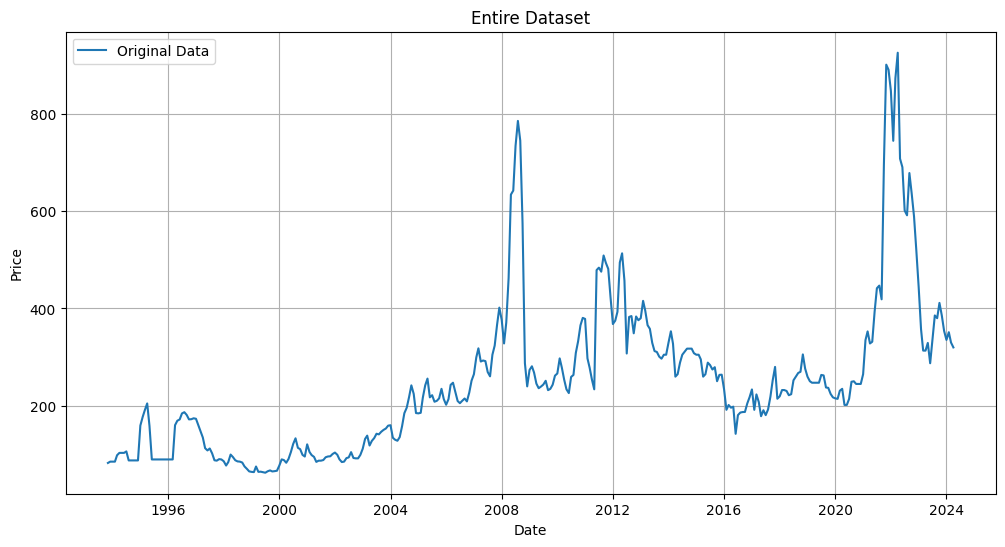

In [70]:
# Plot the entire dataset
plt.figure(figsize=(12, 6))
plt.plot(data.index, data[target_col], label='Original Data')
plt.title('Entire Dataset')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## Detect and Interpolate Null and Zero Values

In [71]:
data[target_col] = data[target_col].replace(0, np.nan)
if data[target_col].isnull().any():
  data[target_col] = data[target_col].interpolate(method='linear')
  data[target_col] = data[target_col].fillna(method='ffill').fillna(method='bfill')

## Reformat to AutoGluon
AutoGluon membutuhkan data dalam format tertentu, yaitu mempunyai kolom:
  - item_id
  - timestamp
  - target

In [72]:
data = data.reset_index()

In [73]:
temp = pd.DataFrame({
    'item_id': target_col,
    'timestamp': data[date_col],
    'target': data[target_col].values
})
temp

,item_id,timestamp,target
0,urea_price,1993-11-01,82.80
1,urea_price,1993-12-01,85.50
2,urea_price,1994-01-01,85.50
3,urea_price,1994-02-01,85.50
4,urea_price,1994-03-01,98.63
...,...,...,...
361,urea_price,2023-12-01,354.00
362,urea_price,2024-01-01,335.38
363,urea_price,2024-02-01,351.25
364,urea_price,2024-03-01,330.00


In [74]:
ag_data = TimeSeriesDataFrame.from_data_frame(
    temp,
    id_column="item_id",
    timestamp_column="timestamp"
)
ag_data.head()

target
item_id    timestamp         
urea_price 1993-11-01   82.80
           1993-12-01   85.50
           1994-01-01   85.50
           1994-02-01   85.50
           1994-03-01   98.63

In [75]:
date_col = 'timestamp'
target_col = 'target'

## Train Test Split

In [76]:
n_test = 6

In [77]:
train_data, test_data = train_test_split(ag_data, test_size=n_test, shuffle=False)

In [78]:
train_data

target
item_id    timestamp         
urea_price 1993-11-01   82.80
           1993-12-01   85.50
           1994-01-01   85.50
           1994-02-01   85.50
           1994-03-01   98.63
...                       ...
           2023-06-01  287.50
           2023-07-01  334.63
           2023-08-01  385.63
           2023-09-01  380.00
           2023-10-01  411.38

[360 rows x 1 columns]

In [79]:
test_data

target
item_id    timestamp         
urea_price 2023-11-01  385.50
           2023-12-01  354.00
           2024-01-01  335.38
           2024-02-01  351.25
           2024-03-01  330.00
           2024-04-01  320.00

# Modeling Chronos
- Chronos dilatih dengan 890,000 data deret waktu univariat dengan total baris 84 milyar.
- Chronos memanfaatkan pretrained language model (seperti LLM). Umumnya LLM digunakan untuk memprediksi kata selanjutnya dalam suatu kalimat.
- Dalam kasus Chronos, model LLM disesuaikan supaya memprediksi nilai selanjutnya dalam deret waktu.
- Data time series diubah menjadi 'token' yang dapat diproses LLM.


## Define Predictor

In [80]:
predictor = TimeSeriesPredictor(
    prediction_length=n_test,
    path="autogluon",
    target="target",
    eval_metric="MASE",
)

## Fit Predictor


> - Specifically, Chronos models do not really fit time series data.
---
> - As promised, Chronos does not take any time to fit.
> - The fit call merely serves as a proxy for the TimeSeriesPredictor to do some of its chores under the hood, such as inferring the frequency of time series and saving the predictor’s state to disk.
---
- Fit tidak digunakan untuk melatih model Chronos
- Hanya untuk mendapatkan frekuensi deret waktu dan menyimpan state predictor

In [81]:
predictor.fit(
    train_data,
    presets="chronos_tiny",
)

Beginning AutoGluon training...
AutoGluon will save models to 'autogluon'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          12
GPU Count:          1
Memory Avail:       47.74 GB / 52.96 GB (90.1%)
Disk Space Avail:   155.32 GB / 201.23 GB (77.2%)
Setting presets to: chronos_tiny

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': {'Chronos': {'model_path': 'tiny'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 6,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 360 rows, 1 time series. Median time ser

## Predict

In [82]:
predictions = predictor.predict(train_data)
predictions

Model not specified in predict, will default to the model with the best validation score: Chronos[tiny]


mean         0.1         0.2         0.3  \
item_id    timestamp                                                    
urea_price 2023-11-01  402.183136  375.792694  383.926746  397.844992   
           2023-12-01  403.990692  376.696469  379.588562  386.999603   
           2024-01-01  392.241547  366.574124  371.273773  373.623618   
           2024-02-01  394.049088  330.061307  357.536310  362.235962   
           2024-03-01  400.375580  332.411133  356.090253  362.235962   
           2024-04-01  411.220947  347.775439  357.174799  364.766562   

                              0.4         0.5         0.6         0.7  \
item_id    timestamp                                                    
urea_price 2023-11-01  401.279358  402.183136  408.148108  419.897278   
           2023-12-01  392.241547  403.990692  404.894470  413.028522   
           2024-01-01  389.710938  392.241547  400.194824  403.629181   
           2024-02-01  384.288269  394.049088  399.471802  402.363892   
           2024-03-01  382.119183  400.375580  409.232635  413.209277   
           2024-04-01  369.827728  411.220947  415.739899  418.993509   

                              0.8         0.9  
item_id    timestamp                           
urea_price 2023-11-01  422.608618  441.407291  
           2023-12-01  421.162567  422.066348  
           2024-01-01  411.763232  438.876688  
           2024-02-01  411.401715  425.681473  
           2024-03-01  418.631989  436.707617  
           2024-04-01  432.730988  444.841675

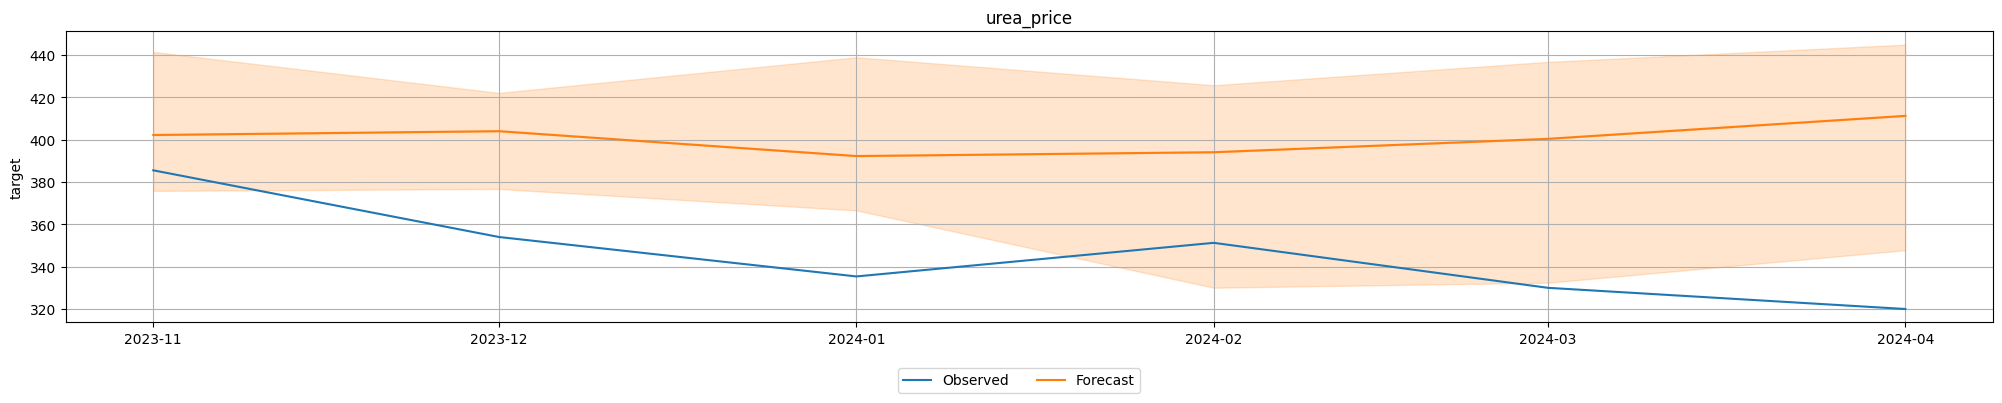

In [83]:
# Plot 4 randomly chosen time series and the respective forecasts
predictor.plot(test_data, predictions, quantile_levels=[0.1, 0.9], max_history_length=300, max_num_item_ids=1);

## Compare

In [84]:
actual = test_data[target_col].values
pred = predictions['mean'].values.flatten()

In [85]:
# Comparison DataFrame
comparison_df = pd.DataFrame({'Actual': actual, 'Predicted': pred})
comparison_df.index = test_data.index.get_level_values('timestamp')
comparison_df

,Actual,Predicted
timestamp,,
2023-11-01,385.50,402.183136
2023-12-01,354.00,403.990692
2024-01-01,335.38,392.241547
2024-02-01,351.25,394.049088
2024-03-01,330.00,400.375580
2024-04-01,320.00,411.220947


## Evaluate

In [86]:
def evaluate_forecast(y_true, y_pred):
    results = {
        'MAPE': mean_absolute_percentage_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }
    return pd.Series(results)

In [87]:
# Evaluating the model on the test predictions
evaluation_results = evaluate_forecast(comparison_df['Actual'], comparison_df['Predicted'])
evaluation_results

,0
MAPE,0.162368
RMSE,59.324499
MAE,54.655165
R2,-6.830759


## Recap

In [88]:
evaluation_summary = pd.DataFrame(columns=['Model Path',
                                           'Batch Size'])

In [89]:
temp_eval = pd.DataFrame([evaluation_results])
temp_eval['Model Path'] = 'Chronos Tiny'
temp_eval['Batch Size'] = 64
evaluation_summary = pd.concat([evaluation_summary, temp_eval], ignore_index=True)
display(evaluation_summary)

,Model Path,Batch Size,MAPE,RMSE,MAE,R2
0,Chronos Tiny,64,0.162368,59.324499,54.655165,-6.830759


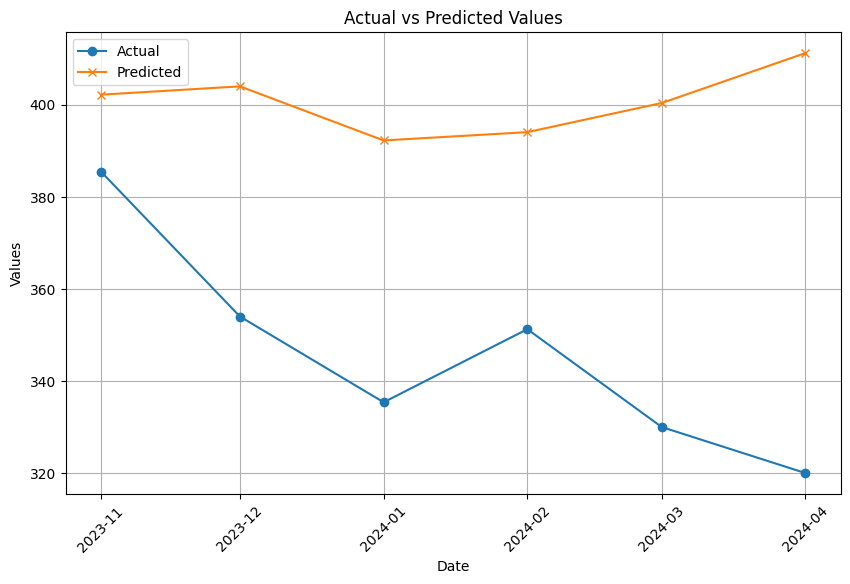

In [90]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(comparison_df['Actual'], label='Actual', marker='o')
plt.plot(comparison_df['Predicted'], label='Predicted', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

# Modeling Chronos + Adjust Model Size
| Model              | Parameters | Based on             |
|--------------------|------------|----------------------|
| chronos-t5-tiny    | 8M         | t5-efficient-tiny    |
| chronos-t5-mini    | 20M        | t5-efficient-mini    |
| chronos-t5-small   | 46M        | t5-efficient-small   |
| chronos-t5-base    | 200M       | t5-efficient-base    |
| chronos-t5-large   | 710M       | t5-efficient-large   |

- Ukuran model tergantung pada ukuran parameter.
- Semakin banyak parameter, model semakin besar, semakin berat. Bisa jadi lebih akurat, tapi lebih lambat.  

## Define Predictor

In [91]:
predictor = TimeSeriesPredictor(
    prediction_length=n_test,
    path="autogluon",
    target="target",
    eval_metric="MASE",
)

## Fit Predictor

In [92]:
predictor.fit(
    train_data,
    presets="chronos_base",
)

Beginning AutoGluon training...
AutoGluon will save models to 'autogluon'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          12
GPU Count:          1
Memory Avail:       48.49 GB / 52.96 GB (91.5%)
Disk Space Avail:   155.32 GB / 201.23 GB (77.2%)
Setting presets to: chronos_base

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': {'Chronos': {'model_path': 'base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 6,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 360 rows, 1 time series. Median time ser

## Predict

In [93]:
predictions = predictor.predict(train_data)
predictions

Model not specified in predict, will default to the model with the best validation score: Chronos[base]


mean         0.1         0.2         0.3  \
item_id    timestamp                                                    
urea_price 2023-11-01  420.258789  375.792694  391.156995  400.737091   
           2023-12-01  414.836090  375.431165  387.541870  394.772125   
           2024-01-01  402.183136  365.670343  372.358307  388.626404   
           2024-02-01  394.952881  341.448965  357.536310  364.585785   
           2024-03-01  409.413406  332.049622  345.967865  362.235962   
           2024-04-01  397.664230  344.883337  358.620844  365.308829   

                              0.4         0.5         0.6         0.7  \
item_id    timestamp                                                    
urea_price 2023-11-01  401.279358  420.258789  425.500726  442.130319   
           2023-12-01  404.171448  414.836090  421.162567  422.247110   
           2024-01-01  393.687579  402.183136  406.340527  428.573587   
           2024-02-01  381.034644  394.952881  409.232635  417.908966   
           2024-03-01  376.696497  409.413406  424.777710  437.249887   
           2024-04-01  375.973437  397.664230  412.486261  421.885608   

                              0.8         0.9  
item_id    timestamp                           
urea_price 2023-11-01  452.252686  455.867801  
           2023-12-01  441.768805  459.663684  
           2024-01-01  447.553015  453.698737  
           2024-02-01  448.637573  467.797736  
           2024-03-01  446.829993  459.302194  
           2024-04-01  449.722083  479.366153

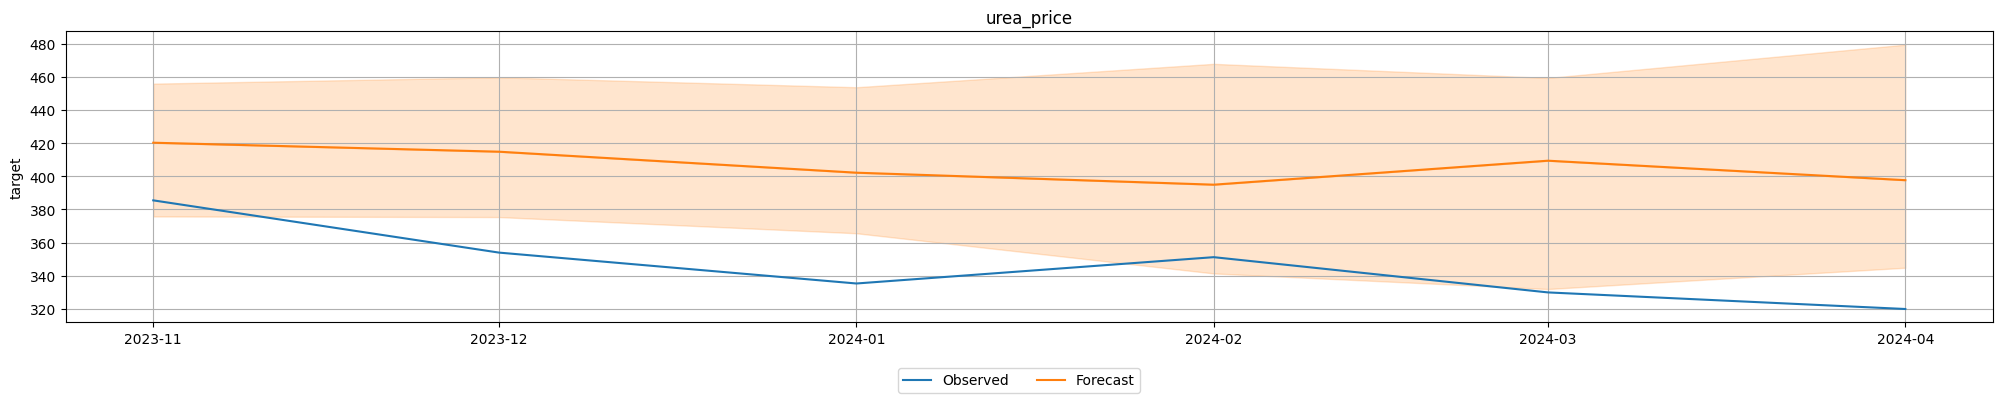

In [94]:
# Plot 4 randomly chosen time series and the respective forecasts
predictor.plot(test_data, predictions, quantile_levels=[0.1, 0.9], max_history_length=300, max_num_item_ids=1);

## Compare

In [95]:
actual = test_data[target_col].values
pred = predictions['mean'].values.flatten()

In [96]:
# Comparison DataFrame
comparison_df = pd.DataFrame({'Actual': actual, 'Predicted': pred})
comparison_df.index = test_data.index.get_level_values('timestamp')
comparison_df

,Actual,Predicted
timestamp,,
2023-11-01,385.50,420.258789
2023-12-01,354.00,414.836090
2024-01-01,335.38,402.183136
2024-02-01,351.25,394.952881
2024-03-01,330.00,409.413406
2024-04-01,320.00,397.664230


## Evaluate

In [97]:
# Evaluating the model on the test predictions
evaluation_results = evaluate_forecast(comparison_df['Actual'], comparison_df['Predicted'])
evaluation_results

,0
MAPE,0.178162
RMSE,62.742896
MAE,60.529755
R2,-7.759207


## Recap

In [98]:
temp_eval = pd.DataFrame([evaluation_results])
temp_eval['Model Path'] = 'Chronos Base'
temp_eval['Batch Size'] = 64
evaluation_summary = pd.concat([evaluation_summary, temp_eval], ignore_index=True)
display(evaluation_summary)

,Model Path,Batch Size,MAPE,RMSE,MAE,R2
0,Chronos Tiny,64,0.162368,59.324499,54.655165,-6.830759
1,Chronos Base,64,0.178162,62.742896,60.529755,-7.759207


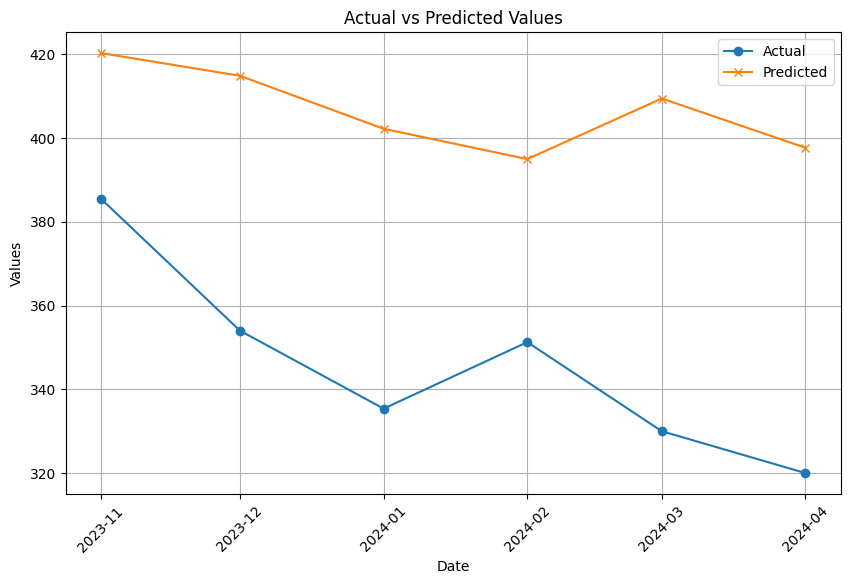

In [99]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(comparison_df['Actual'], label='Actual', marker='o')
plt.plot(comparison_df['Predicted'], label='Predicted', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

# Modeling Chronos + Adjust Model Size + Adjust Batch Size
Bisa pilih
- 8
- 16
- 32
- 64 (default)

## Define Predictor

In [100]:
predictor = TimeSeriesPredictor(
    prediction_length=n_test,
    path="autogluon",
    target="target",
    eval_metric="MASE",
)

## Fit Predictor

In [101]:
predictor.fit(
    train_data,
    hyperparameters={
        "Chronos": {
            "model_path": "base",
            "batch_size": 32,
            "device": "cpu",
        }
    },
)

Beginning AutoGluon training...
AutoGluon will save models to 'autogluon'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          12
GPU Count:          1
Memory Avail:       48.48 GB / 52.96 GB (91.5%)
Disk Space Avail:   155.32 GB / 201.23 GB (77.2%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': {'Chronos': {'batch_size': 32,
                                 'device': 'cpu',
                                 'model_path': 'base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 6,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 

## Predict

In [102]:
predictions = predictor.predict(train_data)
predictions

Model not specified in predict, will default to the model with the best validation score: Chronos[base]


mean         0.1         0.2         0.3  \
item_id    timestamp                                                    
urea_price 2023-11-01  427.489044  393.687589  404.894470  412.847769   
           2023-12-01  416.643661  382.661462  393.687585  404.352203   
           2024-01-01  418.451218  389.710956  395.856659  405.617493   
           2024-02-01  426.585266  372.177551  392.241528  400.917838   
           2024-03-01  417.547440  370.369995  380.311584  391.880026   
           2024-04-01  423.873917  340.002924  360.066876  394.049103   

                              0.4         0.5         0.6         0.7  \
item_id    timestamp                                                    
urea_price 2023-11-01  419.716522  427.489044  432.369458  439.057443   
           2023-12-01  407.786578  416.643661  438.153656  442.130319   
           2024-01-01  410.317169  418.451218  435.984589  442.130319   
           2024-02-01  417.547430  426.585266  435.623077  445.383929   
           2024-03-01  402.725409  417.547440  428.392822  437.792151   
           2024-04-01  412.847784  423.873917  437.069122  449.179819   

                              0.8         0.9  
item_id    timestamp                           
urea_price 2023-11-01  445.022430  448.456818  
           2023-12-01  457.675385  462.375040  
           2024-01-01  452.252692  461.652011  
           2024-02-01  466.351672  484.788849  
           2024-03-01  473.943439  492.380621  
           2024-04-01  488.042456  502.322208

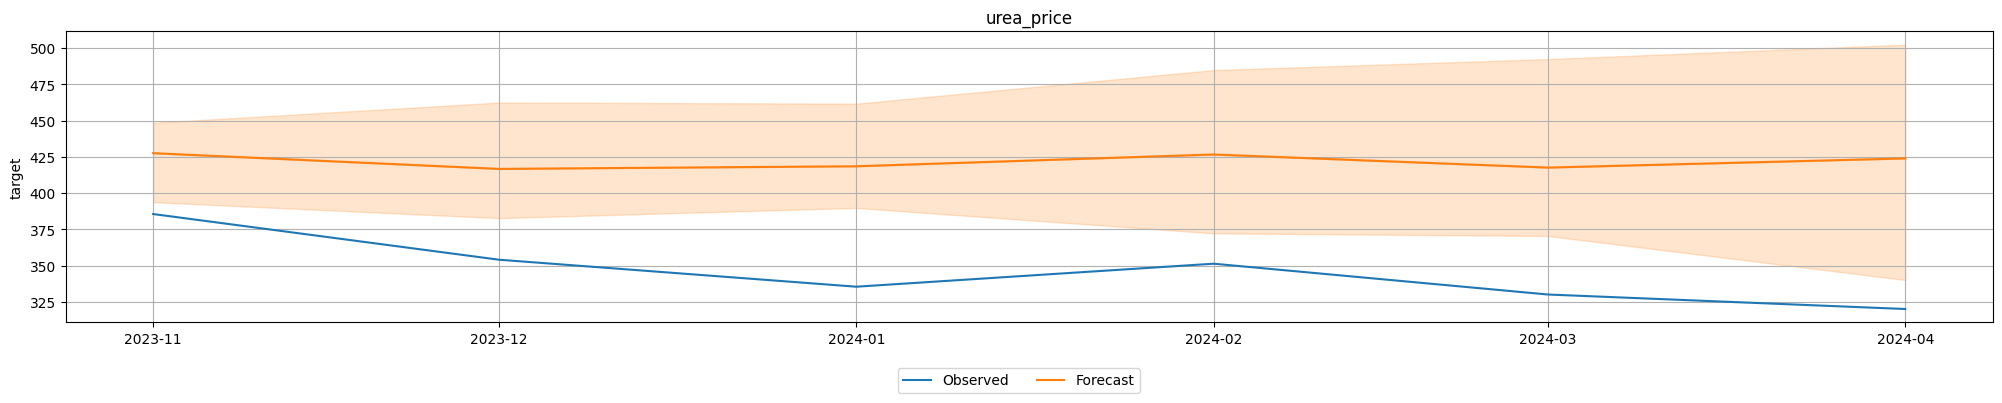

In [103]:
# Plot 4 randomly chosen time series and the respective forecasts
predictor.plot(test_data, predictions, quantile_levels=[0.1, 0.9], max_history_length=300, max_num_item_ids=1);

## Compare

In [104]:
actual = test_data[target_col].values
pred = predictions['mean'].values.flatten()

In [105]:
# Comparison DataFrame
comparison_df = pd.DataFrame({'Actual': actual, 'Predicted': pred})
comparison_df.index = test_data.index.get_level_values('timestamp')
comparison_df

,Actual,Predicted
timestamp,,
2023-11-01,385.50,427.489044
2023-12-01,354.00,416.643661
2024-01-01,335.38,418.451218
2024-02-01,351.25,426.585266
2024-03-01,330.00,417.547440
2024-04-01,320.00,423.873917


## Evaluate

In [106]:
# Evaluating the model on the test predictions
evaluation_results = evaluate_forecast(comparison_df['Actual'], comparison_df['Predicted'])
evaluation_results

,0
MAPE,0.222992
RMSE,78.228173
MAE,75.743424
R2,-12.616392


## Recap

In [107]:
temp_eval = pd.DataFrame([evaluation_results])
temp_eval['Model Path'] = 'Chronos Base'
temp_eval['Batch Size'] = 32
evaluation_summary = pd.concat([evaluation_summary, temp_eval], ignore_index=True)
display(evaluation_summary)

,Model Path,Batch Size,MAPE,RMSE,MAE,R2
0,Chronos Tiny,64,0.162368,59.324499,54.655165,-6.830759
1,Chronos Base,64,0.178162,62.742896,60.529755,-7.759207
2,Chronos Base,32,0.222992,78.228173,75.743424,-12.616392


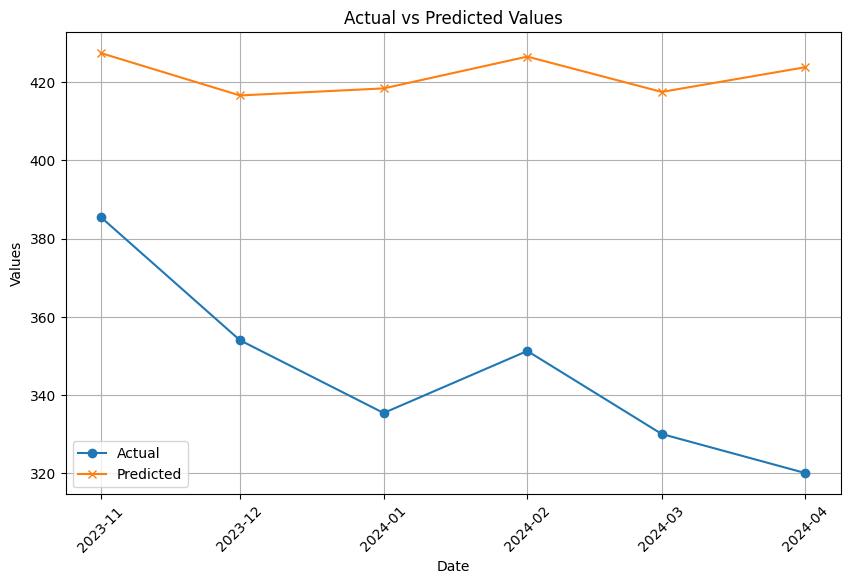

In [108]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(comparison_df['Actual'], label='Actual', marker='o')
plt.plot(comparison_df['Predicted'], label='Predicted', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

# Modeling - Chronos Ensemble
`chronos_small` digabung dengan model-model ringan (statistik, berbasis tree, dan deep learning)

## Define Predictor

In [109]:
predictor = TimeSeriesPredictor(
    prediction_length=n_test,
    path="autogluon",
    target="target",
    eval_metric="MASE",
)

## Fit Predictor

In [110]:
predictor.fit(
    train_data,
    presets="chronos_ensemble",
    time_limit=600,
    num_val_windows=3
)

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'autogluon'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          12
GPU Count:          1
Memory Avail:       48.48 GB / 52.96 GB (91.5%)
Disk Space Avail:   155.32 GB / 201.23 GB (77.2%)
Setting presets to: chronos_ensemble

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': {'Chronos': {'model_path': 'small'},
                     'DirectTabular': {},
                     'PatchTST': {},
                     'RecursiveTabular': {},
                     'SeasonalNaive': {},
                     'TemporalFusionTransformer': {}},
 'known_covariates_names': [],
 'num_val_windows': 3,
 'prediction_length': 6,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],


## Predict

In [111]:
predictions = predictor.predict(train_data)
predictions

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean         0.1         0.2         0.3  \
item_id    timestamp                                                    
urea_price 2023-11-01  422.561325  350.397659  373.504835  393.773817   
           2023-12-01  402.822082  304.338963  340.123246  363.857666   
           2024-01-01  386.167211  270.148625  308.637776  338.533214   
           2024-02-01  373.041677  233.167366  280.920017  312.875818   
           2024-03-01  362.639234  208.894171  256.059927  294.162621   
           2024-04-01  353.018809  187.901511  250.151374  286.796387   

                              0.4         0.5         0.6         0.7  \
item_id    timestamp                                                    
urea_price 2023-11-01  407.304319  422.561325  438.627966  455.558950   
           2023-12-01  386.646572  402.822082  422.721935  442.920010   
           2024-01-01  362.785749  386.167211  407.119751  432.181926   
           2024-02-01  342.527677  373.041677  398.212082  427.459112   
           2024-03-01  323.973637  362.639234  397.256628  426.581868   
           2024-04-01  320.219328  353.018809  397.639021  428.714020   

                              0.8         0.9  
item_id    timestamp                           
urea_price 2023-11-01  473.884803  498.044507  
           2023-12-01  464.873230  503.329321  
           2024-01-01  468.554462  508.258081  
           2024-02-01  462.896355  519.474069  
           2024-03-01  466.303832  526.747660  
           2024-04-01  478.232269  538.134186

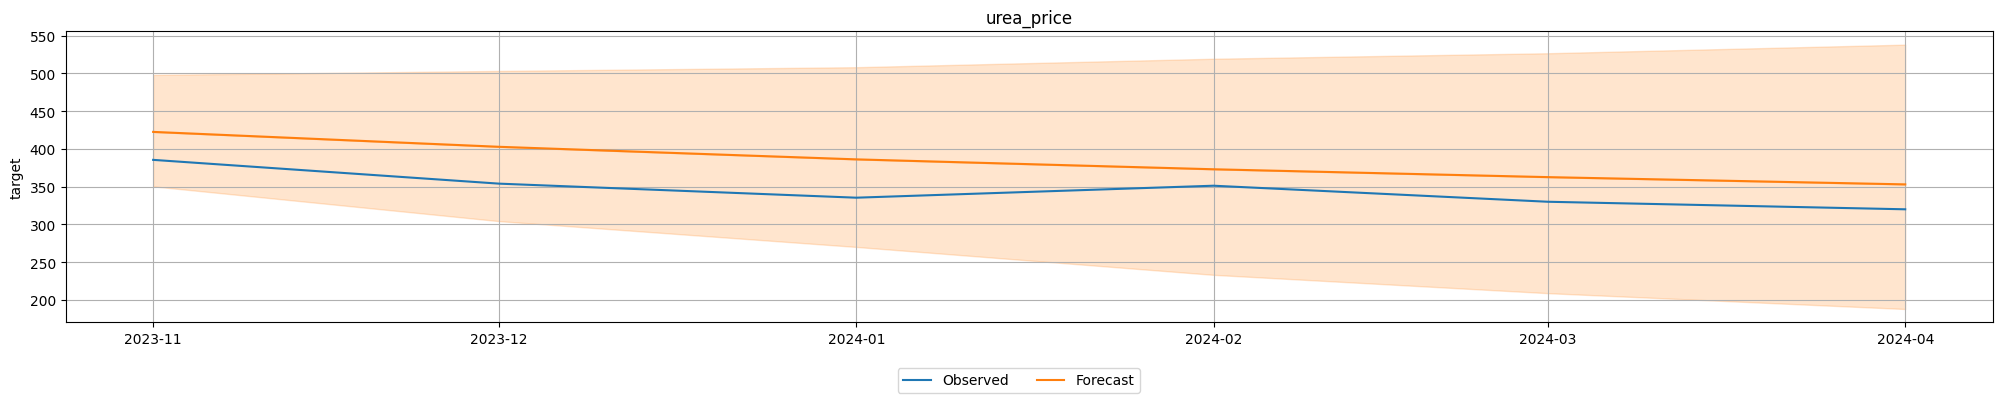

In [112]:
# Plot 4 randomly chosen time series and the respective forecasts
predictor.plot(test_data, predictions, quantile_levels=[0.1, 0.9], max_history_length=300, max_num_item_ids=1);

## Compare

In [113]:
actual = test_data[target_col].values
pred = predictions['mean'].values.flatten()

In [114]:
# Comparison DataFrame
comparison_df = pd.DataFrame({'Actual': actual, 'Predicted': pred})
comparison_df.index = test_data.index.get_level_values('timestamp')
comparison_df

,Actual,Predicted
timestamp,,
2023-11-01,385.50,422.561325
2023-12-01,354.00,402.822082
2024-01-01,335.38,386.167211
2024-02-01,351.25,373.041677
2024-03-01,330.00,362.639234
2024-04-01,320.00,353.018809


## Evaluate

In [115]:
# Evaluating the model on the test predictions
evaluation_results = evaluate_forecast(comparison_df['Actual'], comparison_df['Predicted'])
evaluation_results

,0
MAPE,0.108269
RMSE,38.658584
MAE,37.353390
R2,-2.325275


## Recap

In [116]:
temp_eval = pd.DataFrame([evaluation_results])
temp_eval['Model Path'] = 'Chronos Ensemble'
temp_eval['Batch Size'] = 64
evaluation_summary = pd.concat([evaluation_summary, temp_eval], ignore_index=True)
display(evaluation_summary)

,Model Path,Batch Size,MAPE,RMSE,MAE,R2
0,Chronos Tiny,64,0.162368,59.324499,54.655165,-6.830759
1,Chronos Base,64,0.178162,62.742896,60.529755,-7.759207
2,Chronos Base,32,0.222992,78.228173,75.743424,-12.616392
3,Chronos Ensemble,64,0.108269,38.658584,37.353390,-2.325275


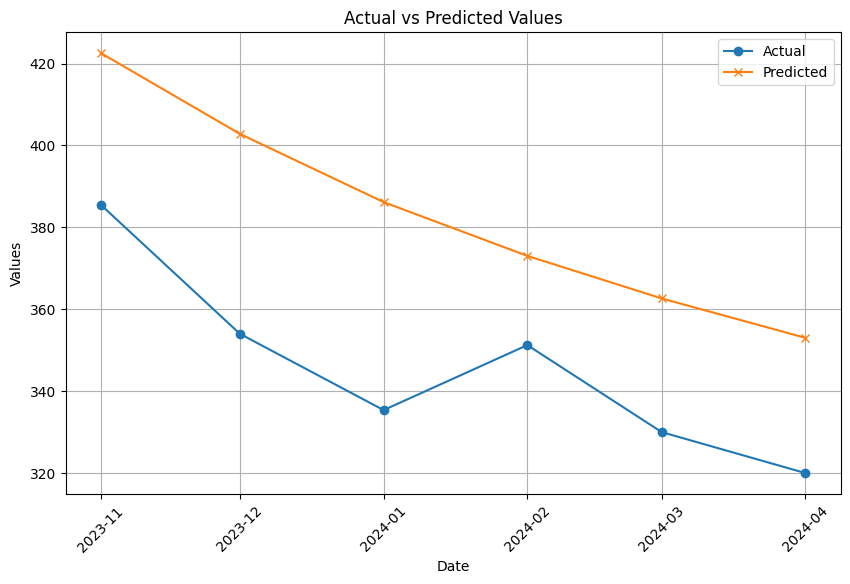

In [117]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(comparison_df['Actual'], label='Actual', marker='o')
plt.plot(comparison_df['Predicted'], label='Predicted', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

# Modeling - Chronos Large Ensemble
`chronos_large` digabung dengan model-model ringan (statistik, berbasis tree, dan deep learning)

## Define Predictor

In [118]:
predictor = TimeSeriesPredictor(
    prediction_length=n_test,
    path="autogluon",
    target="target",
    eval_metric="MASE",
)

## Fit Predictor

In [119]:
predictor.fit(
    train_data,
    presets="chronos_large_ensemble",
    time_limit=600,
    num_val_windows=3
)

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'autogluon'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          12
GPU Count:          1
Memory Avail:       48.15 GB / 52.96 GB (90.9%)
Disk Space Avail:   155.32 GB / 201.23 GB (77.2%)
Setting presets to: chronos_large_ensemble

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': {'Chronos': {'batch_size': 8, 'model_path': 'large'},
                     'DirectTabular': {},
                     'PatchTST': {},
                     'RecursiveTabular': {},
                     'SeasonalNaive': {},
                     'TemporalFusionTransformer': {}},
 'known_covariates_names': [],
 'num_val_windows': 3,
 'prediction_length': 6,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5

## Predict

In [120]:
predictions = predictor.predict(train_data)
predictions

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean         0.1         0.2         0.3  \
item_id    timestamp                                                    
urea_price 2023-11-01  422.843049  351.632285  374.658019  394.952163   
           2023-12-01  403.570808  293.748188  340.011046  361.512400   
           2024-01-01  384.710351  258.925823  309.913792  334.512265   
           2024-02-01  367.742438  224.906686  269.384062  305.084383   
           2024-03-01  353.568150  205.000776  255.193544  292.936054   
           2024-04-01  355.051327  177.419929  244.241089  286.278887   

                              0.4         0.5         0.6         0.7  \
item_id    timestamp                                                    
urea_price 2023-11-01  408.416056  422.843049  439.258353  452.639400   
           2023-12-01  381.806683  403.570808  419.701363  440.244199   
           2024-01-01  359.911136  384.710351  407.189858  429.606235   
           2024-02-01  337.728605  367.742438  395.436553  424.684055   
           2024-03-01  324.327584  353.568150  387.116749  427.124337   
           2024-04-01  320.539355  355.051327  393.208566  428.794589   

                              0.8         0.9  
item_id    timestamp                           
urea_price 2023-11-01  475.004713  499.355993  
           2023-12-01  463.651010  501.712054  
           2024-01-01  463.483551  505.938312  
           2024-02-01  467.757747  517.537307  
           2024-03-01  466.026686  520.858887  
           2024-04-01  463.044802  534.671064

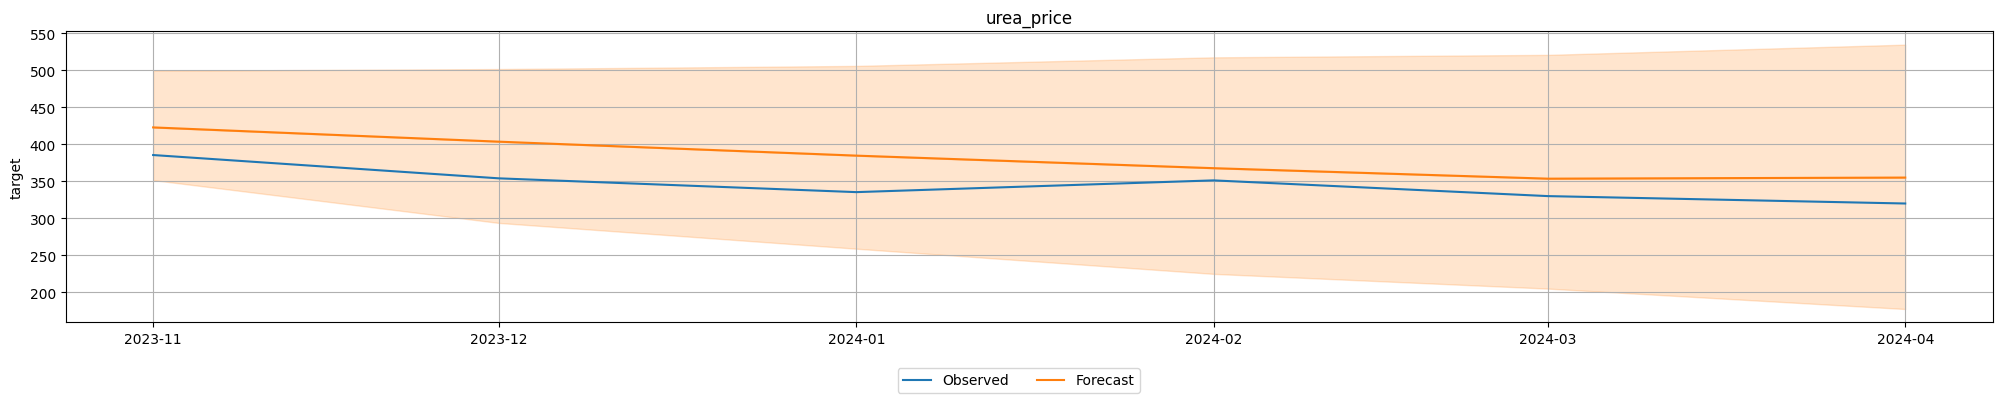

In [121]:
# Plot 4 randomly chosen time series and the respective forecasts
predictor.plot(test_data, predictions, quantile_levels=[0.1, 0.9], max_history_length=300, max_num_item_ids=1);

## Compare

In [122]:
actual = test_data[target_col].values
pred = predictions['mean'].values.flatten()

In [123]:
# Comparison DataFrame
comparison_df = pd.DataFrame({'Actual': actual, 'Predicted': pred})
comparison_df.index = test_data.index.get_level_values('timestamp')
comparison_df

,Actual,Predicted
timestamp,,
2023-11-01,385.50,422.843049
2023-12-01,354.00,403.570808
2024-01-01,335.38,384.710351
2024-02-01,351.25,367.742438
2024-03-01,330.00,353.568150
2024-04-01,320.00,355.051327


## Evaluate

In [124]:
# Evaluating the model on the test predictions
evaluation_results = evaluate_forecast(comparison_df['Actual'], comparison_df['Predicted'])
evaluation_results

,0
MAPE,0.101983
RMSE,37.285622
MAE,35.226021
R2,-2.093274


## Recap

In [125]:
temp_eval = pd.DataFrame([evaluation_results])
temp_eval['Model Path'] = 'Chronos Ensemble Large'
temp_eval['Batch Size'] = 64
evaluation_summary = pd.concat([evaluation_summary, temp_eval], ignore_index=True)
display(evaluation_summary)

,Model Path,Batch Size,MAPE,RMSE,MAE,R2
0,Chronos Tiny,64,0.162368,59.324499,54.655165,-6.830759
1,Chronos Base,64,0.178162,62.742896,60.529755,-7.759207
2,Chronos Base,32,0.222992,78.228173,75.743424,-12.616392
3,Chronos Ensemble,64,0.108269,38.658584,37.353390,-2.325275
4,Chronos Ensemble Large,64,0.101983,37.285622,35.226021,-2.093274


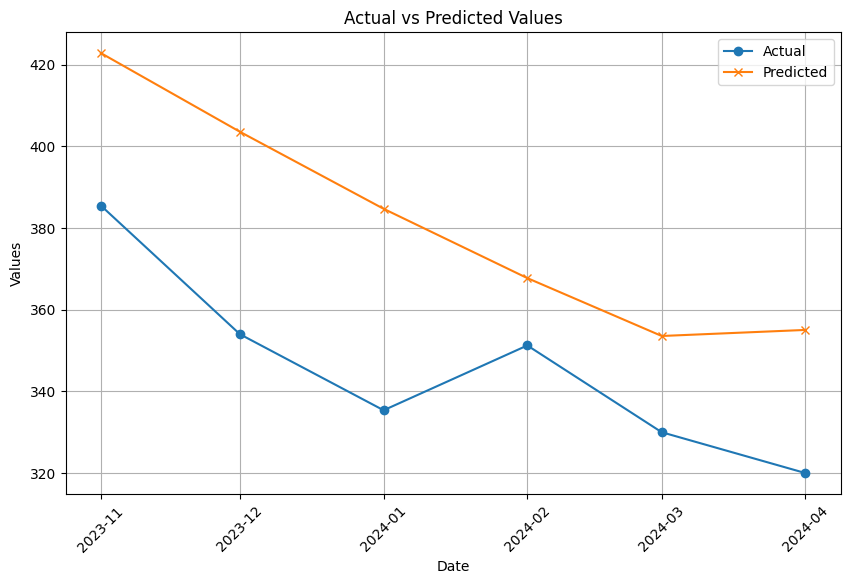

In [126]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(comparison_df['Actual'], label='Actual', marker='o')
plt.plot(comparison_df['Predicted'], label='Predicted', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()